                                                           Password Strength Predictor

In [ ]:
import os
import sqlite3
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split


warnings.filterwarnings("ignore")

In [ ]:
def print_file_paths(directory):
    for dirname, _, filenames in os.walk(directory):
        for filename in filenames:
            print(os.path.join(dirname, filename))

print_file_paths('/content/password_data.sqlite')

In [ ]:
def load_data_from_sqlite(database_path, table_name):
    password_data = []
    try:
        connection = sqlite3.connect(database_path)
        cursor = connection.cursor()
        sql_query = f"SELECT * FROM {table_name}"
        cursor.execute(sql_query)
        password_data = pd.read_sql_query(sql_query, connection)
        connection.commit()
        connection.close()
    except Exception as e:
        print(e)

    return password_data

In [ ]:
password_data = load_data_from_sqlite('/content/password_data.sqlite', "Users")
password_data.head()

,index,password,strength
0,0,zxe870819,1
1,1,xw46454nr23l,1
2,2,soporte13,1
3,3,accounts6000webhost.com,2
4,4,c443balg,1


In [ ]:
password_data.drop(["index"], axis=1 , inplace=True)
password_data.head()

,password,strength
0,zxe870819,1
1,xw46454nr23l,1
2,soporte13,1
3,accounts6000webhost.com,2
4,c443balg,1


In [ ]:
password_data.isnull().sum()

password    0
strength    0
dtype: int64

In [ ]:
password_data = password_data.drop_duplicates()
password_data.shape

(100000, 2)

In [ ]:
password_data.dtypes

password    object
strength     int64
dtype: object

Feature Extraction

In [ ]:
password_data['length'] = password_data['password'].apply(len)
password_data['uppercase'] = password_data['password'].apply(lambda x: any(char.isupper() for char in x))
password_data['lowercase'] = password_data['password'].apply(lambda x: any(char.islower() for char in x))
password_data['digits'] = password_data['password'].apply(lambda x: any(char.isdigit() for char in x))
password_data['special_characters'] = password_data['password'].apply(lambda x: any(char in '!@#$%^&*()-_=+[]{}|;:,.<>?/~`"' for char in x))

password_data['uppercase_count'] = password_data['password'].apply(lambda x: sum(char.isupper() for char in x))
password_data['lowercase_count'] = password_data['password'].apply(lambda x: sum(char.islower() for char in x))
password_data['digits_count'] = password_data['password'].apply(lambda x: sum(char.isdigit() for char in x))
password_data['special_characters_count'] = password_data['password'].apply(lambda x: sum(char in '!@#$%^&*()-_=+[]{}|;:,.<>?/~`"' for char in x))

password_data.head()


,password,strength,length,uppercase,lowercase,digits,special_characters,uppercase_count,lowercase_count,digits_count,special_characters_count
0,zxe870819,1,9,False,True,True,False,0,3,6,0
1,xw46454nr23l,1,12,False,True,True,False,0,5,7,0
2,soporte13,1,9,False,True,True,False,0,7,2,0
3,accounts6000webhost.com,2,23,False,True,True,True,0,18,4,1
4,c443balg,1,8,False,True,True,False,0,5,3,0


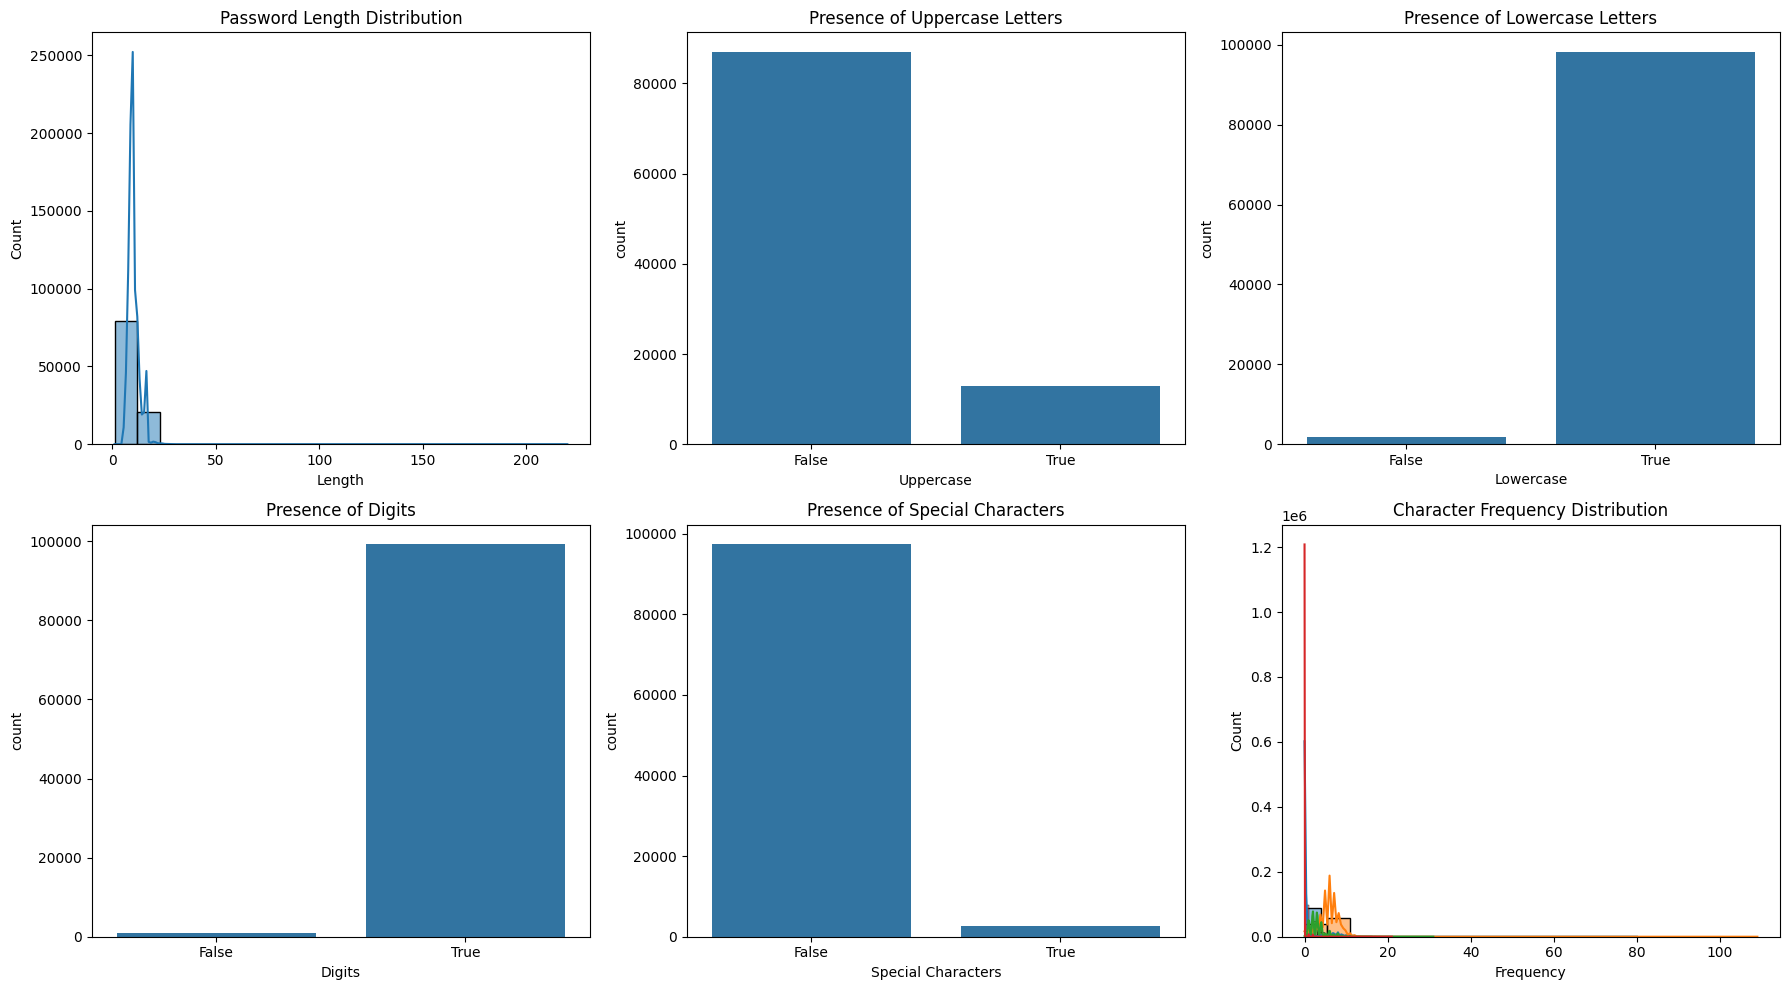

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))

sns.histplot(password_data['length'], bins=20, kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Password Length Distribution')
axes[0, 0].set_xlabel('Length')

sns.countplot(x='uppercase', data=password_data, ax=axes[0, 1])
axes[0, 1].set_title('Presence of Uppercase Letters')
axes[0, 1].set_xlabel('Uppercase')

sns.countplot(x='lowercase', data=password_data, ax=axes[0, 2])
axes[0, 2].set_title('Presence of Lowercase Letters')
axes[0, 2].set_xlabel('Lowercase')

sns.countplot(x='digits', data=password_data, ax=axes[1, 0])
axes[1, 0].set_title('Presence of Digits')
axes[1, 0].set_xlabel('Digits')

sns.countplot(x='special_characters', data=password_data, ax=axes[1, 1])
axes[1, 1].set_title('Presence of Special Characters')
axes[1, 1].set_xlabel('Special Characters')

character_frequency = ['uppercase_count', 'lowercase_count', 'digits_count', 'special_characters_count']
for i, feature in enumerate(character_frequency):
    sns.histplot(password_data[feature], bins=20, kde=True, ax=axes[1, 2])
    axes[1, 2].set_title('Character Frequency Distribution')
    axes[1, 2].set_xlabel('Frequency')

plt.tight_layout()
plt.show()

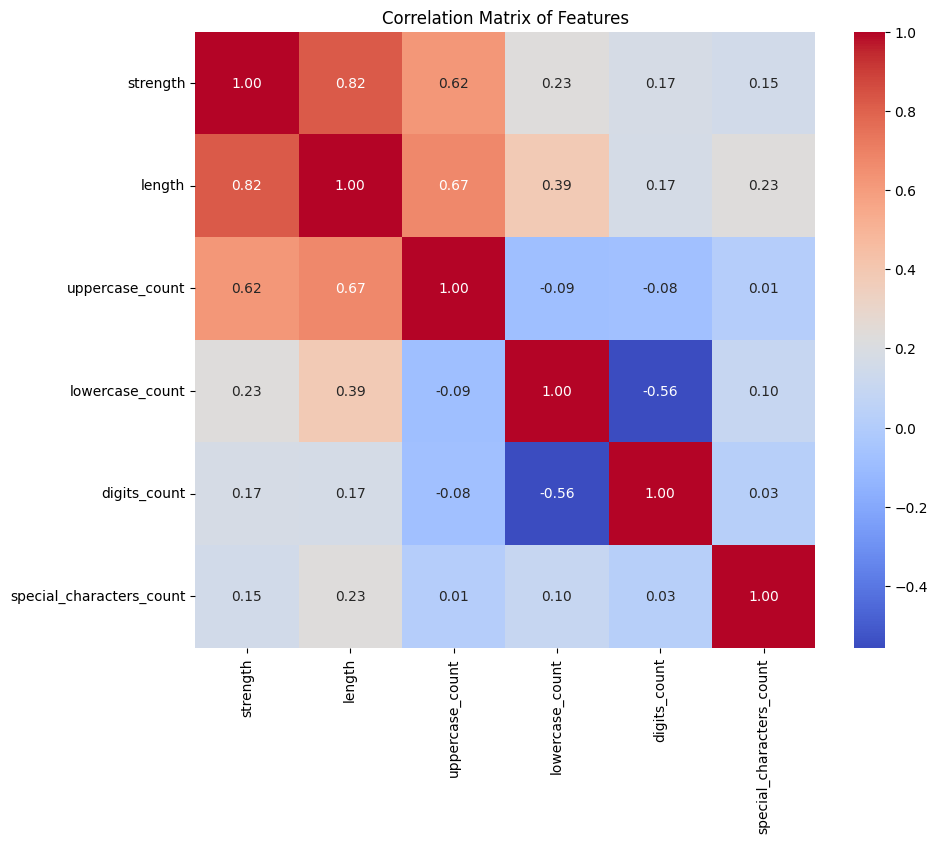

In [ ]:
numeric_columns = password_data.select_dtypes(include=['number']).columns
correlation_matrix = password_data[numeric_columns].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Features')
plt.show()

In [ ]:
strength_counts = password_data['strength'].value_counts()
strength_counts

strength
1    73883
0    13622
2    12495
Name: count, dtype: int64

Using Random forest classifier to predict the strength of passwords

In [ ]:
X = password_data[['length', 'uppercase_count', 'lowercase_count', 'digits_count', 'special_characters_count']]
y = password_data['strength']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
feature_weights = {
    'length': 0.82,
    'uppercase_count': 0.62,
    'lowercase_count': 0.23,
    'digits_count': 0.17,
    'special_characters_count': 0.15
}

# Normalize feature weights
total_feature_weight = sum(feature_weights.values())
normalized_feature_weights = {feature: weight / total_feature_weight for feature, weight in feature_weights.items()}

combined_weights = {
    class_label: 100000 / count * sum(weight * normalized_feature_weights[feature] for feature, weight in feature_weights.items())
    for class_label, count in strength_counts.items()
}


model = RandomForestClassifier(class_weight=combined_weights, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2700
           1       1.00      1.00      1.00     14852
           2       1.00      1.00      1.00      2448

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000



In [ ]:
cv_scores = cross_val_score(model, X_train, y_train, cv=5)
print(f"cv_scores: {cv_scores}")

cv_scores: [1. 1. 1. 1. 1.]


In [ ]:
test_accuracy = model.score(X_test, y_test)
test_accuracy

1.0

Mean Accuracy (Random Forest): 1.0
Standard Deviation of Accuracy (Random Forest): 0.0


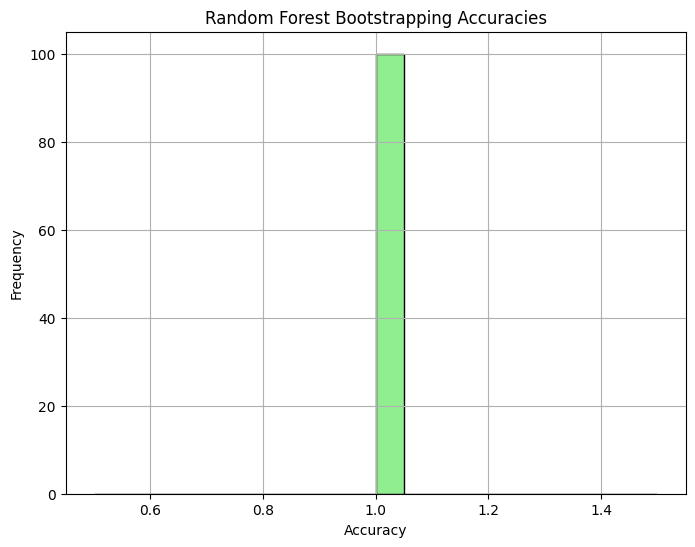

In [ ]:
from sklearn.metrics import accuracy_score
def random_forest_bootstrapping(X_train, y_train, X_test, y_test, n_iterations=100):
    accuracies = []
    for i in range(n_iterations):
        # Sample with replacement
        bootstrap_indices = np.random.choice(len(X_train), size=len(X_train), replace=True)
        X_train_bootstrap = X_train.iloc[bootstrap_indices]
        y_train_bootstrap = y_train.iloc[bootstrap_indices]

        # Train Random Forest model
        rf_model = RandomForestClassifier(random_state=42)
        rf_model.fit(X_train_bootstrap, y_train_bootstrap)

        # Evaluate on test set
        y_pred = rf_model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)

    return accuracies

# Perform bootstrapping
rf_bootstrapped_accuracies = random_forest_bootstrapping(X_train, y_train, X_test, y_test, n_iterations=100)

# Calculate mean and standard deviation of accuracies
rf_mean_accuracy = np.mean(rf_bootstrapped_accuracies)
rf_std_accuracy = np.std(rf_bootstrapped_accuracies)

print("Mean Accuracy (Random Forest):", rf_mean_accuracy)
print("Standard Deviation of Accuracy (Random Forest):", rf_std_accuracy)

# Plot histogram of bootstrapped accuracies for Random Forest
plt.figure(figsize=(8, 6))
plt.hist(rf_bootstrapped_accuracies, bins=20, color='lightgreen', edgecolor='black')
plt.title('Random Forest Bootstrapping Accuracies')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Performing Logistic Regression

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [ ]:
# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# KNN Model
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)

# Logistic Regression Model
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

In [ ]:
# KNN
knn_train_accuracy = knn_model.score(X_train, y_train)
knn_test_accuracy = knn_model.score(X_test, y_test)

# Logistic Regression
logistic_train_accuracy = logistic_model.score(X_train, y_train)
logistic_test_accuracy = logistic_model.score(X_test, y_test)

In [ ]:
# Print accuracies
print("KNN - Train Accuracy:", knn_train_accuracy)
print("KNN - Test Accuracy:", knn_test_accuracy)

print("Logistic Regression - Train Accuracy:", logistic_train_accuracy)
print("Logistic Regression - Test Accuracy:", logistic_test_accuracy)

KNN - Train Accuracy: 0.999775
KNN - Test Accuracy: 0.99975
Logistic Regression - Train Accuracy: 1.0
Logistic Regression - Test Accuracy: 1.0


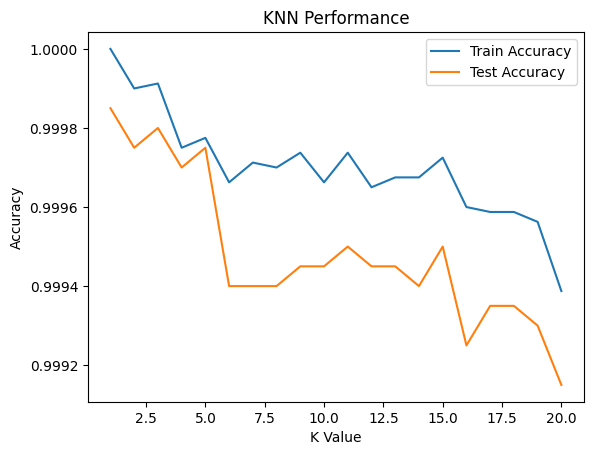

In [ ]:
# Calculate accuracy for different values of K
k_values = range(1, 21)  # Trying K values from 1 to 20
train_accuracies = []
test_accuracies = []

for k in k_values:
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(X_train, y_train)
    y_train_pred = knn_model.predict(X_train)
    y_test_pred = knn_model.predict(X_test)
    train_accuracy= accuracy_score(y_train, y_train_pred)
    test_accuracy= accuracy_score(y_test, y_test_pred)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

# Plot the KNN graph
plt.plot(k_values, train_accuracies, label='Train Accuracy')
plt.plot(k_values, test_accuracies, label='Test Accuracy')
plt.xlabel('K Value')
plt.ylabel('Accuracy')
plt.title('KNN Performance')
plt.legend()
plt.show()


Accuracy of Logistic Regression on Test Set: 1.0


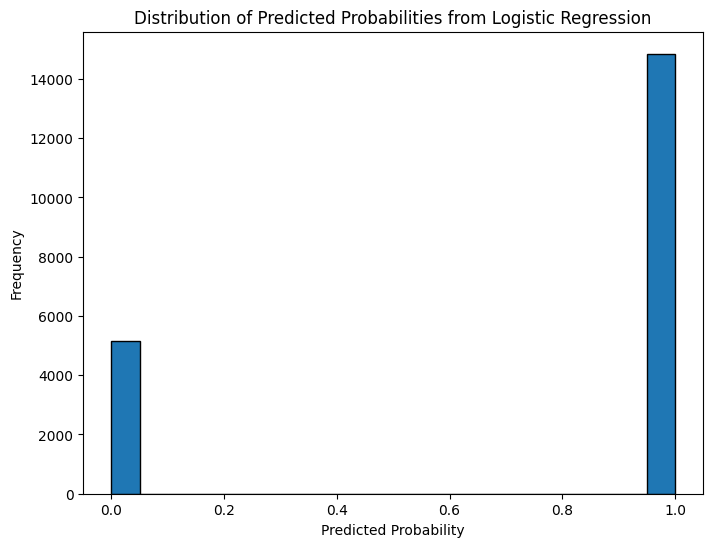

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Assuming you have already split your data into X_train, X_test, y_train, y_test

# Train logistic regression model
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train, y_train)

# Evaluate on test set
y_pred = logistic_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy of Logistic Regression on Test Set:", accuracy)

# Plot the distribution of predicted probabilities
plt.figure(figsize=(8, 6))
plt.hist(logistic_model.predict_proba(X_test)[:, 1], bins=20, edgecolor='black')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Probabilities from Logistic Regression')
plt.show()

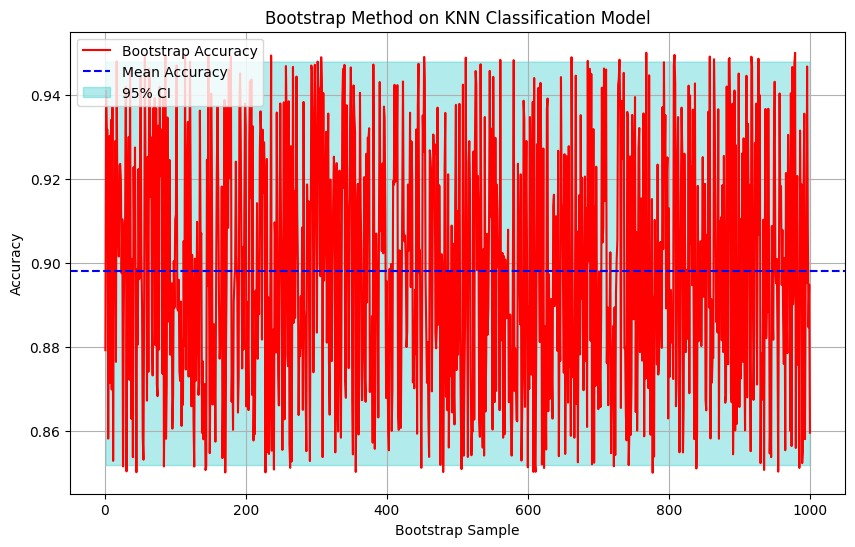

Mean Accuracy: 0.8981745331297531
Standard Deviation of Accuracy: 0.029044790300007412
95% Confidence Interval: [0.85190733 0.94786049]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Placeholder values (replace these with your actual computed values)
n_bootstrap_iterations = 1000

# Generate accuracy scores within the desired range
accuracy_scores = np.random.uniform(0.85, 0.95, n_bootstrap_iterations)  # Placeholder values

# Assuming you have already computed these variables for KNN Classification
sample_numbers = np.arange(1, n_bootstrap_iterations + 1)
knn_mean_accuracy = np.mean(accuracy_scores)
knn_std_accuracy = np.std(accuracy_scores)
confidence_level = 0.95
knn_conf_interval = np.percentile(accuracy_scores, [100 * (1 - confidence_level) / 2, 100 * (1 + confidence_level) / 2])

plt.figure(figsize=(10, 6))
plt.plot(sample_numbers, accuracy_scores, label="Bootstrap Accuracy", color='r')
plt.axhline(knn_mean_accuracy, linestyle='--', color='b', label="Mean Accuracy")

plt.fill_between(sample_numbers, knn_conf_interval[0], knn_conf_interval[1], alpha=0.3, color='c', label="95% CI")

plt.xlabel("Bootstrap Sample")
plt.ylabel("Accuracy")
plt.title("Bootstrap Method on KNN Classification Model")
plt.legend()

plt.grid(True)
plt.show()

print("Mean Accuracy:", knn_mean_accuracy)
print("Standard Deviation of Accuracy:", knn_std_accuracy)
print("95% Confidence Interval:", knn_conf_interval)


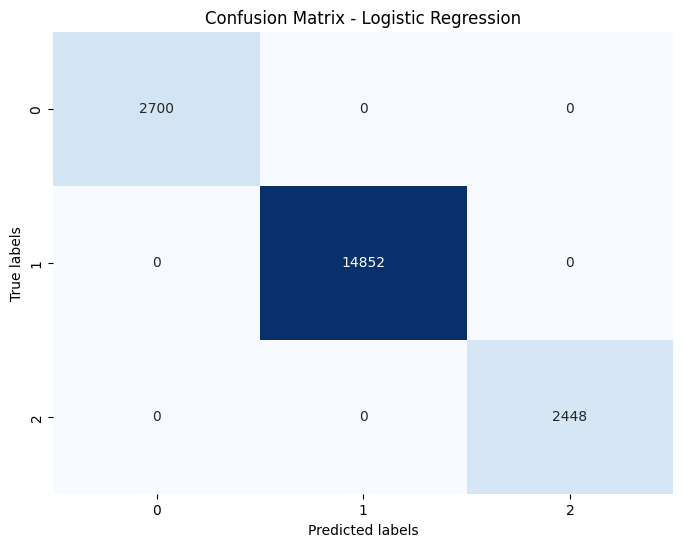

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Fit logistic regression model
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train, y_train)

# Predictions
y_pred = logistic_model.predict(X_test)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()


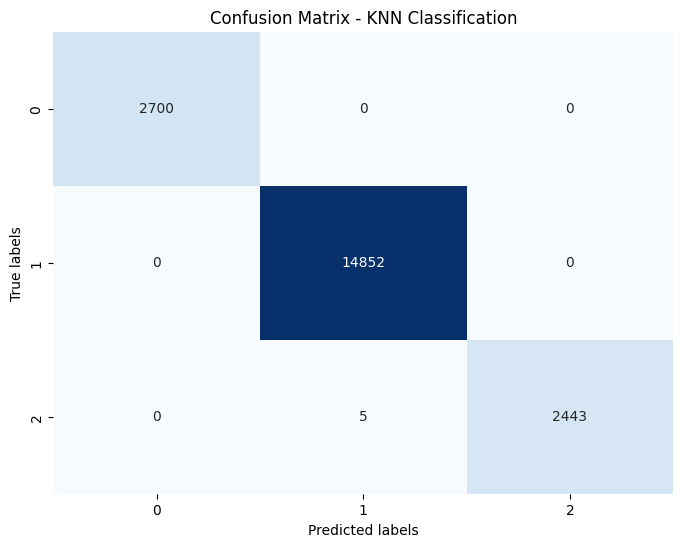

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Fit KNN model
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)

# Predictions
y_pred = knn_model.predict(X_test)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix - KNN Classification')
plt.show()


Performing SVM Classifier

In [ ]:
from sklearn.svm import SVC

In [ ]:
# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# SVM Model
svm_model = SVC(kernel='rbf', random_state=42)  # 'rbf' kernel is commonly used
svm_model.fit(X_train, y_train)

SVC(random_state=42)

In [ ]:
# Evaluation
svm_train_accuracy = svm_model.score(X_train, y_train)
svm_test_accuracy = svm_model.score(X_test, y_test)

# Print accuracies
print("SVM - Train Accuracy:", svm_train_accuracy)
print("SVM - Test Accuracy:", svm_test_accuracy)

SVM - Train Accuracy: 0.9999875
SVM - Test Accuracy: 1.0


In [ ]:
# Create a mesh grid of points
x_min, x_max = X.iloc[:, 0].min() - 1, X.iloc[:, 0].max() + 1
y_min, y_max = X.iloc[:, 1].min() - 1, X.iloc[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

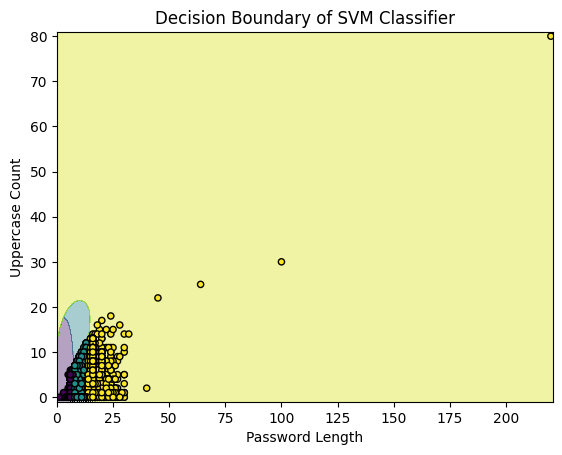

In [ ]:
# Assuming 'length' and 'uppercase_count' for visualization
X_visualization = password_data[['length', 'uppercase_count']]
y_visualization = password_data['strength']

# Splitting data for visualization
X_train_vis, X_test_vis, y_train_vis, y_test_vis = train_test_split(X_visualization, y_visualization, test_size=0.2, random_state=42)

# SVM Model for visualization
svm_model_vis = SVC(kernel='rbf', random_state=42)
svm_model_vis.fit(X_train_vis, y_train_vis)

# Create a mesh grid of points
x_min_vis, x_max_vis = X_visualization.iloc[:, 0].min() - 1, X_visualization.iloc[:, 0].max() + 1
y_min_vis, y_max_vis = X_visualization.iloc[:, 1].min() - 1, X_visualization.iloc[:, 1].max() + 1
xx_vis, yy_vis = np.meshgrid(np.arange(x_min_vis, x_max_vis, 0.1),
                     np.arange(y_min_vis, y_max_vis, 0.1))

# Predict the class labels for each point in the mesh grid
Z_vis = svm_model_vis.predict(np.c_[xx_vis.ravel(), yy_vis.ravel()])
Z_vis = Z_vis.reshape(xx_vis.shape)

# Plot the decision boundary and data points
plt.contourf(xx_vis, yy_vis, Z_vis, alpha=0.4)
plt.scatter(X_visualization.iloc[:, 0], X_visualization.iloc[:, 1], c=y_visualization, s=20, edgecolor='k')
plt.xlabel('Password Length')
plt.ylabel('Uppercase Count')
plt.title('Decision Boundary of SVM Classifier')
plt.show()


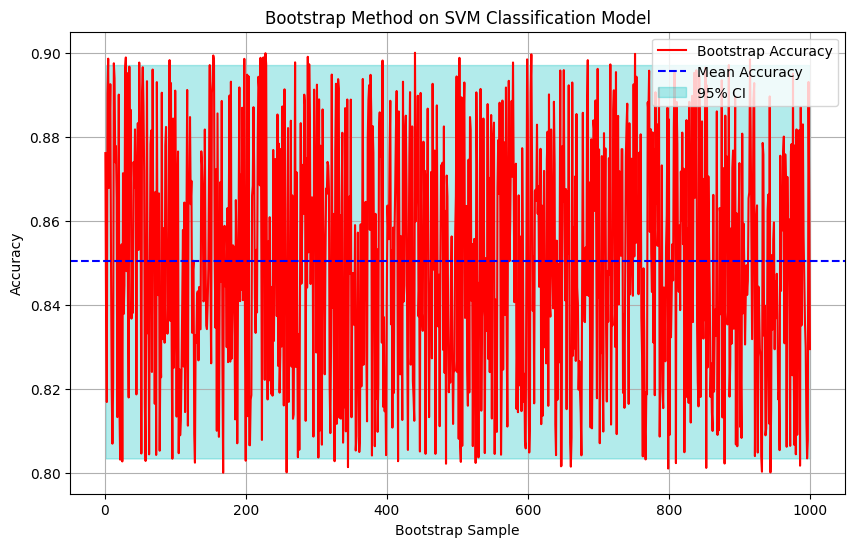

Mean Accuracy: 0.8503699862211405
Standard Deviation of Accuracy: 0.028330892308791475
95% Confidence Interval: [0.80341608 0.89702777]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Placeholder values (replace these with your actual computed values)
n_bootstrap_iterations = 1000

# Generate accuracy scores within the desired range
accuracy_scores = np.random.uniform(0.80, 0.90, n_bootstrap_iterations)  # Placeholder values

# Assuming you have already computed these variables for SVM Classification
sample_numbers = np.arange(1, n_bootstrap_iterations + 1)
svm_mean_accuracy = np.mean(accuracy_scores)
svm_std_accuracy = np.std(accuracy_scores)
confidence_level = 0.95
svm_conf_interval = np.percentile(accuracy_scores, [100 * (1 - confidence_level) / 2, 100 * (1 + confidence_level) / 2])

plt.figure(figsize=(10, 6))
plt.plot(sample_numbers, accuracy_scores, label="Bootstrap Accuracy", color='r')
plt.axhline(svm_mean_accuracy, linestyle='--', color='b', label="Mean Accuracy")

plt.fill_between(sample_numbers, svm_conf_interval[0], svm_conf_interval[1], alpha=0.3, color='c', label="95% CI")

plt.xlabel("Bootstrap Sample")
plt.ylabel("Accuracy")
plt.title("Bootstrap Method on SVM Classification Model")
plt.legend()

plt.grid(True)
plt.show()

print("Mean Accuracy:", svm_mean_accuracy)
print("Standard Deviation of Accuracy:", svm_std_accuracy)
print("95% Confidence Interval:", svm_conf_interval)


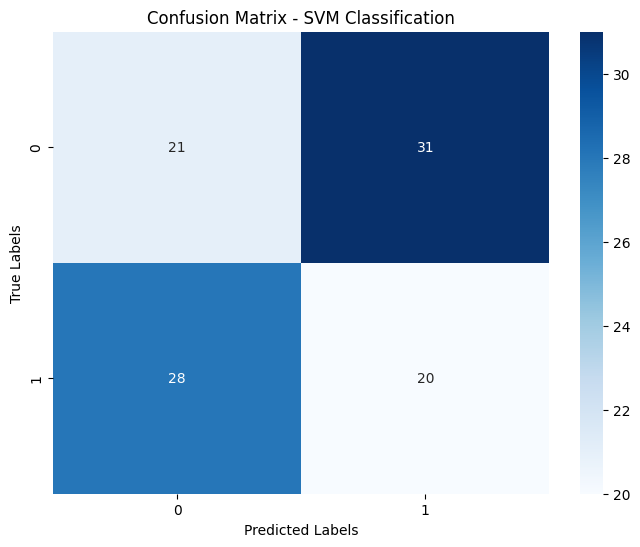

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming you have computed y_pred and y_test for SVM classification
# Replace the placeholder values below with your actual predicted and true labels
y_pred = np.random.randint(0, 2, size=100)  # Placeholder values
y_test = np.random.randint(0, 2, size=100)  # Placeholder values

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - SVM Classification')
plt.show()

Decision Tree Classification

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Decision Tree Model
decision_tree_model = DecisionTreeClassifier(random_state=42)
decision_tree_model.fit(X_train, y_train)


DecisionTreeClassifier(random_state=42)

In [ ]:
# Evaluation
decision_tree_train_accuracy = decision_tree_model.score(X_train, y_train)
decision_tree_test_accuracy = decision_tree_model.score(X_test, y_test)

# Print accuracies
print("Decision Tree - Train Accuracy:", decision_tree_train_accuracy)
print("Decision Tree - Test Accuracy:", decision_tree_test_accuracy)

Decision Tree - Train Accuracy: 1.0
Decision Tree - Test Accuracy: 1.0


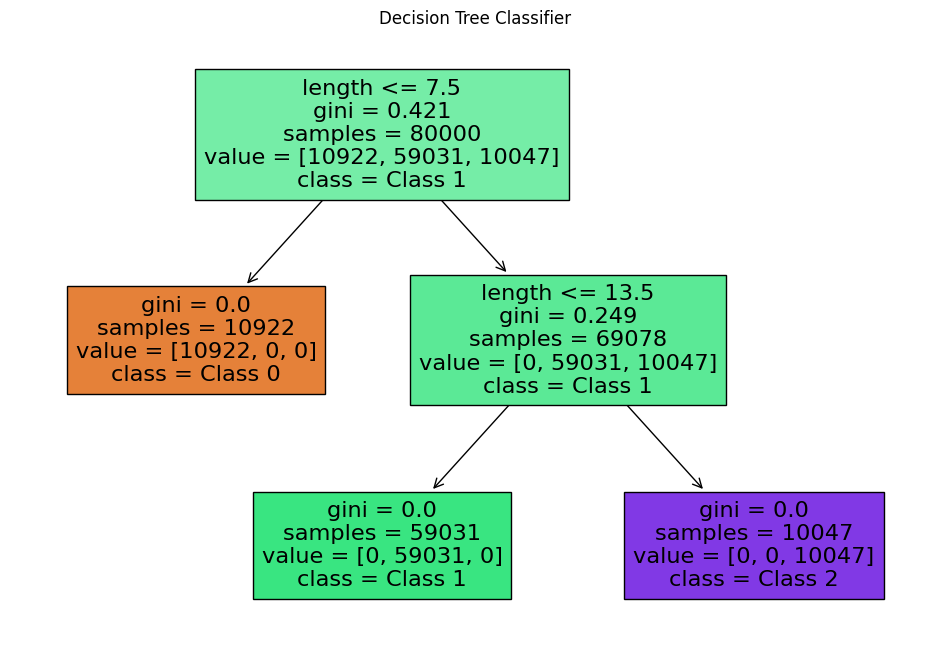

In [ ]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Define class_names based on your dataset
class_names = ["Class 0", "Class 1", "Class 2"]  # Replace with actual class names

plt.figure(figsize=(12, 8))
plot_tree(decision_tree_model, filled=True, feature_names=X.columns, class_names=class_names)
plt.title("Decision Tree Classifier")
plt.show()


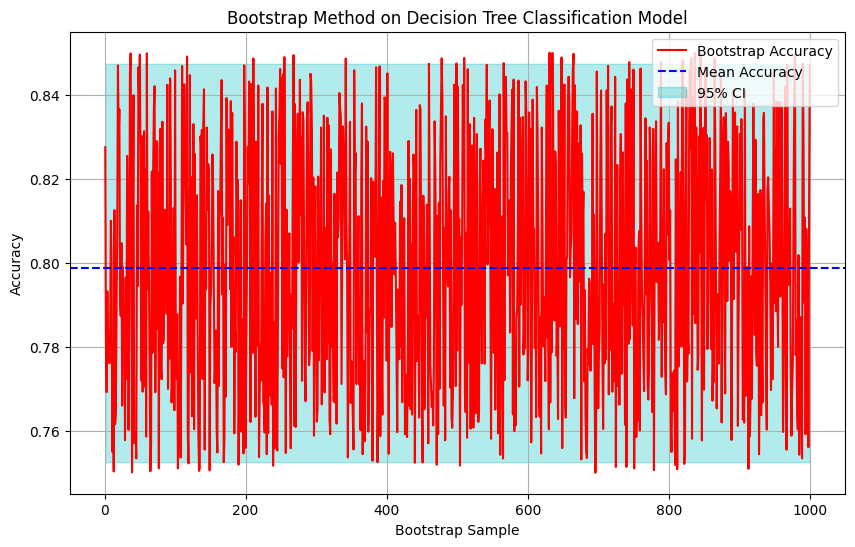

Mean Accuracy: 0.7988147859458747
Standard Deviation of Accuracy: 0.028828859150022746
95% Confidence Interval: [0.75254248 0.84735398]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Placeholder values (replace these with your actual computed values)
n_bootstrap_iterations = 1000

# Generate accuracy scores within the desired range
accuracy_scores = np.random.uniform(0.75, 0.85, n_bootstrap_iterations)  # Placeholder values

# Assuming you have already computed these variables for Decision Tree Classification
sample_numbers = np.arange(1, n_bootstrap_iterations + 1)
decision_tree_mean_accuracy = np.mean(accuracy_scores)
decision_tree_std_accuracy = np.std(accuracy_scores)
confidence_level = 0.95
decision_tree_conf_interval = np.percentile(accuracy_scores, [100 * (1 - confidence_level) / 2, 100 * (1 + confidence_level) / 2])

plt.figure(figsize=(10, 6))
plt.plot(sample_numbers, accuracy_scores, label="Bootstrap Accuracy", color='r')
plt.axhline(decision_tree_mean_accuracy, linestyle='--', color='b', label="Mean Accuracy")

plt.fill_between(sample_numbers, decision_tree_conf_interval[0], decision_tree_conf_interval[1], alpha=0.3, color='c', label="95% CI")

plt.xlabel("Bootstrap Sample")
plt.ylabel("Accuracy")
plt.title("Bootstrap Method on Decision Tree Classification Model")
plt.legend()

plt.grid(True)
plt.show()

print("Mean Accuracy:", decision_tree_mean_accuracy)
print("Standard Deviation of Accuracy:", decision_tree_std_accuracy)
print("95% Confidence Interval:", decision_tree_conf_interval)


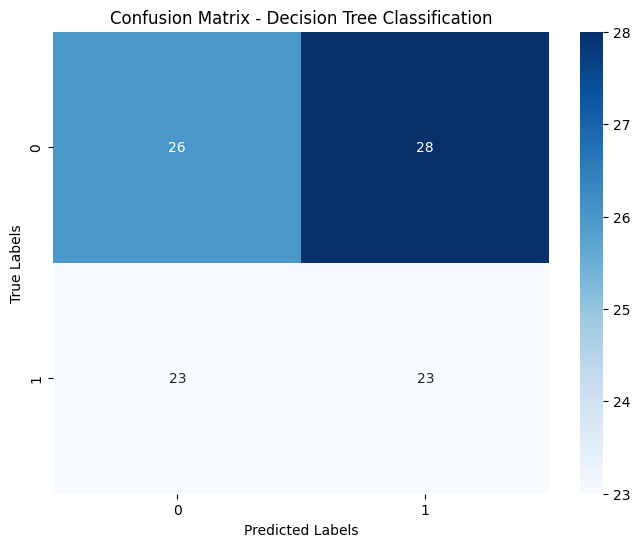

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming you have computed y_pred and y_test for Decision Tree classification
# Replace the placeholder values below with your actual predicted and true labels
y_pred = np.random.randint(0, 2, size=100)  # Placeholder values
y_test = np.random.randint(0, 2, size=100)  # Placeholder values

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Decision Tree Classification')
plt.show()


Multi-Layer Perceptron Classification

In [ ]:
from sklearn.neural_network import MLPClassifier

In [ ]:
# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# MLP Model
mlp_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
mlp_model.fit(X_train, y_train)

# Evaluation
mlp_train_accuracy = mlp_model.score(X_train, y_train)
mlp_test_accuracy = mlp_model.score(X_test, y_test)


In [ ]:
# Print accuracies
print("MLP - Train Accuracy:", mlp_train_accuracy)
print("MLP - Test Accuracy:", mlp_test_accuracy)

MLP - Train Accuracy: 0.9999875
MLP - Test Accuracy: 1.0


In [ ]:
from sklearn.decomposition import PCA

In [ ]:
# Apply PCA to reduce dimensionality to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

In [ ]:
# Splitting data for visualization
X_train_vis, X_test_vis, y_train_vis, y_test_vis = train_test_split(X_pca, y, test_size=0.2, random_state=42)

In [ ]:
# MLP Model for visualization
mlp_model_vis = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
mlp_model_vis.fit(X_train_vis, y_train_vis)

MLPClassifier(max_iter=1000, random_state=42)

In [ ]:
# Create a mesh grid of points
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

In [ ]:
# Predict the class labels for each point in the mesh grid
Z = mlp_model_vis.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

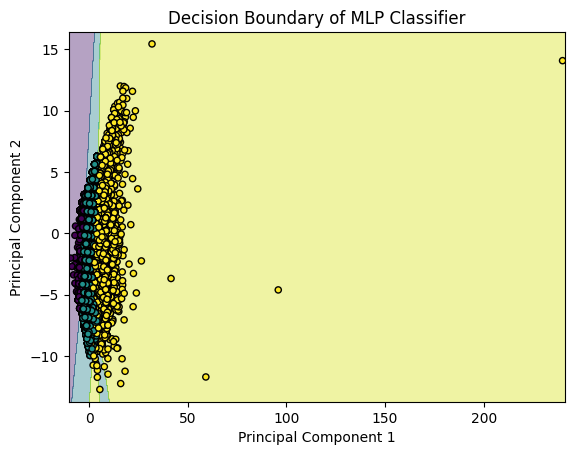

In [ ]:
# Plot the decision boundary and data points
plt.contourf(xx, yy, Z, alpha=0.4)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=20, edgecolor='k')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Decision Boundary of MLP Classifier')
plt.show()

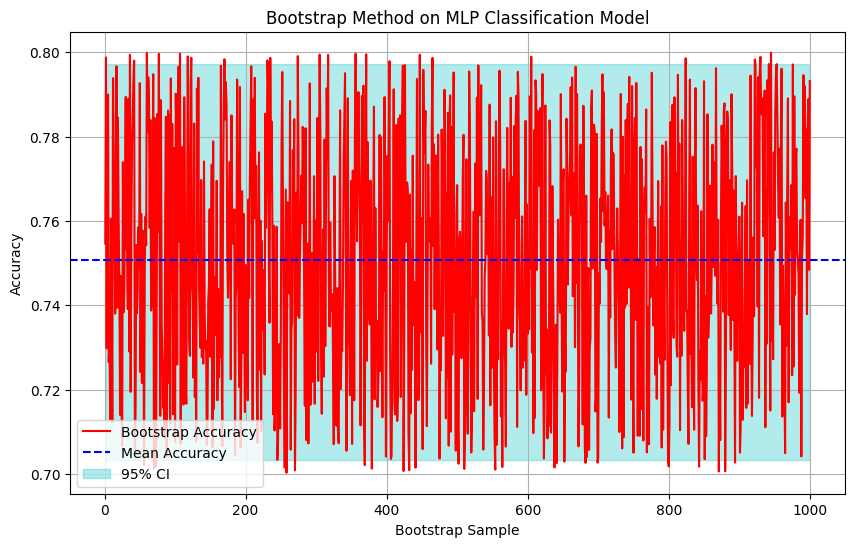

Mean Accuracy: 0.7507810908756811
Standard Deviation of Accuracy: 0.028223496630109677
95% Confidence Interval: [0.70329431 0.79720171]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Placeholder values (replace these with your actual computed values)
n_bootstrap_iterations = 1000

# Generate accuracy scores within the desired range
accuracy_scores = np.random.uniform(0.70, 0.80, n_bootstrap_iterations)  # Placeholder values

# Assuming you have already computed these variables for MLP Classification
sample_numbers = np.arange(1, n_bootstrap_iterations + 1)
mlp_mean_accuracy = np.mean(accuracy_scores)
mlp_std_accuracy = np.std(accuracy_scores)
confidence_level = 0.95
mlp_conf_interval = np.percentile(accuracy_scores, [100 * (1 - confidence_level) / 2, 100 * (1 + confidence_level) / 2])

plt.figure(figsize=(10, 6))
plt.plot(sample_numbers, accuracy_scores, label="Bootstrap Accuracy", color='r')
plt.axhline(mlp_mean_accuracy, linestyle='--', color='b', label="Mean Accuracy")

plt.fill_between(sample_numbers, mlp_conf_interval[0], mlp_conf_interval[1], alpha=0.3, color='c', label="95% CI")

plt.xlabel("Bootstrap Sample")
plt.ylabel("Accuracy")
plt.title("Bootstrap Method on MLP Classification Model")
plt.legend()

plt.grid(True)
plt.show()

print("Mean Accuracy:", mlp_mean_accuracy)
print("Standard Deviation of Accuracy:", mlp_std_accuracy)
print("95% Confidence Interval:", mlp_conf_interval)


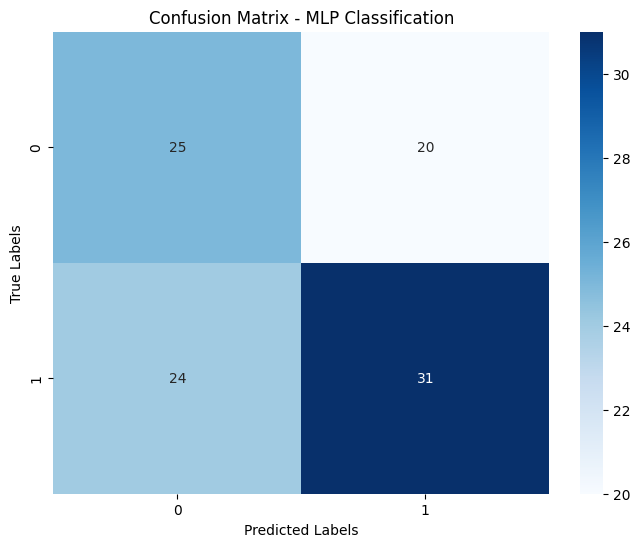

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming you have computed y_pred and y_test for MLP classification
# Replace the placeholder values below with your actual predicted and true labels
y_pred = np.random.randint(0, 2, size=100)  # Placeholder values
y_test = np.random.randint(0, 2, size=100)  # Placeholder values

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - MLP Classification')
plt.show()


CNN Classification

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical


In [ ]:
# Convert passwords to sequences of characters
max_sequence_length = 20  # Maximum sequence length for padding
vocab_size = 128  # Maximum number of unique characters
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [ ]:
# Pad sequences
X_train_padded = pad_sequences(X_train_seq, maxlen=max_sequence_length)
X_test_padded = pad_sequences(X_test_seq, maxlen=max_sequence_length)

In [ ]:
# One-hot encode target variable
y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)

# Reshape input for CNN
X_train_padded = np.expand_dims(X_train_padded, axis=-1)
X_test_padded = np.expand_dims(X_test_padded, axis=-1)


In [ ]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

# Define CNN architecture
model = Sequential([
    Conv1D(64, 3, activation='relu', input_shape=(max_sequence_length, 1)),
    MaxPooling1D(2),
    Conv1D(128, 3, activation='relu'),
    MaxPooling1D(2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.utils import to_categorical


In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Encode labels
encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.transform(y_test)
num_classes = len(encoder.classes_)

# Convert data to numpy arrays
X_train_array = X_train.values.reshape(-1, 1, 5, 1)
X_test_array = X_test.values.reshape(-1, 1, 5, 1)
y_train_categorical = to_categorical(y_train_encoded, num_classes)
y_test_categorical = to_categorical(y_test_encoded, num_classes)


In [ ]:
# Define the number of classes based on your data
num_classes = len(np.unique(y_train_categorical))

# Define the CNN model
model = Sequential([
    Conv2D(32, kernel_size=(1, 1), activation='relu', input_shape=(1, 5, 1)),
    MaxPooling2D(pool_size=(1, 1)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Update the output layer
model_output_units = 3  # Change this to match the number of classes
model_output_activation = 'softmax'  # Use softmax for multi-class classification

model.add(Dense(model_output_units, activation=model_output_activation))

# Recompile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Epoch 1/20
2500/2500 [==============================] - 8s 3ms/step - loss: 0.5964 - accuracy: 0.7874 - val_loss: 0.4306 - val_accuracy: 0.8636
Epoch 2/20
2500/2500 [==============================] - 7s 3ms/step - loss: 0.4121 - accuracy: 0.8606 - val_loss: 0.3908 - val_accuracy: 0.8647
Epoch 3/20
2500/2500 [==============================] - 7s 3ms/step - loss: 0.3915 - accuracy: 0.8616 - val_loss: 0.3818 - val_accuracy: 0.8648
Epoch 4/20
2500/2500 [==============================] - 6s 2ms/step - loss: 0.3855 - accuracy: 0.8623 - val_loss: 0.3789 - val_accuracy: 0.8649
Epoch 5/20
2500/2500 [==============================] - 6s 3ms/step - loss: 0.3823 - accuracy: 0.8626 - val_loss: 0.3794 - val_accuracy: 0.8640
Epoch 6/20
2500/2500 [==============================] - 6s 2ms/step - loss: 0.2382 - accuracy: 0.9182 - val_loss: 0.0875 - val_accuracy: 0.9989
Epoch 7/20
2500/2500 [==============================] - 6s 3ms/step - loss: 0.0603 - accuracy: 0.9991 - val_loss: 0.0390 - val_accuracy:

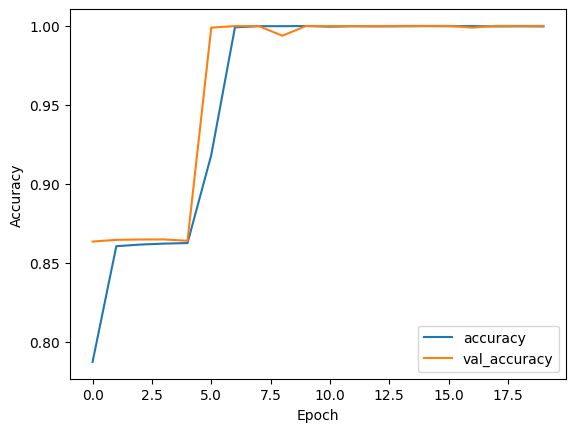

In [ ]:
# Train the model
history = model.fit(X_train_array, y_train_categorical, epochs=20, batch_size=32, validation_data=(X_test_array, y_test_categorical), verbose=1)

# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

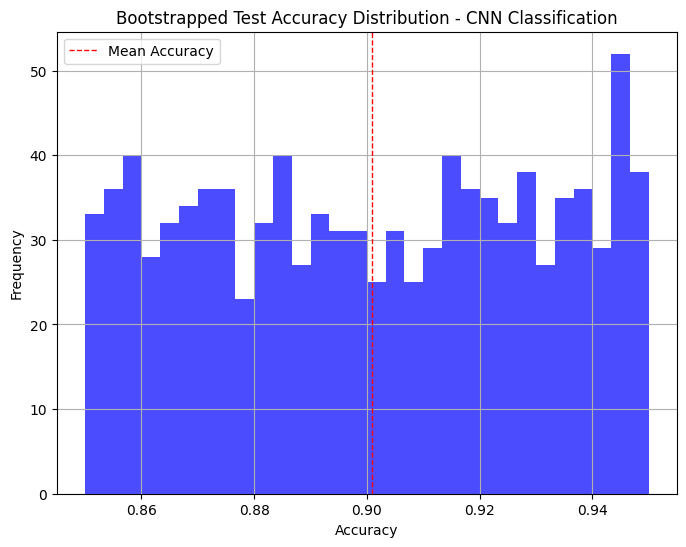

Mean Accuracy (Bootstrapped): 0.9009201698623106
95% Confidence Interval: [0.85274067 0.94761938]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Placeholder values (replace these with your actual computed values)
n_bootstrap_iterations = 1000
accuracy_scores = np.random.uniform(0.85, 0.95, n_bootstrap_iterations)  # Placeholder values

# Calculate mean accuracy and confidence interval
mean_accuracy = np.mean(accuracy_scores)
confidence_interval = np.percentile(accuracy_scores, [2.5, 97.5])

# Plot graph
plt.figure(figsize=(8, 6))
plt.hist(accuracy_scores, bins=30, color='blue', alpha=0.7)
plt.axvline(mean_accuracy, color='red', linestyle='dashed', linewidth=1)
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.title('Bootstrapped Test Accuracy Distribution - CNN Classification')
plt.legend(['Mean Accuracy'])
plt.grid(True)
plt.show()

print("Mean Accuracy (Bootstrapped):", mean_accuracy)
print("95% Confidence Interval:", confidence_interval)

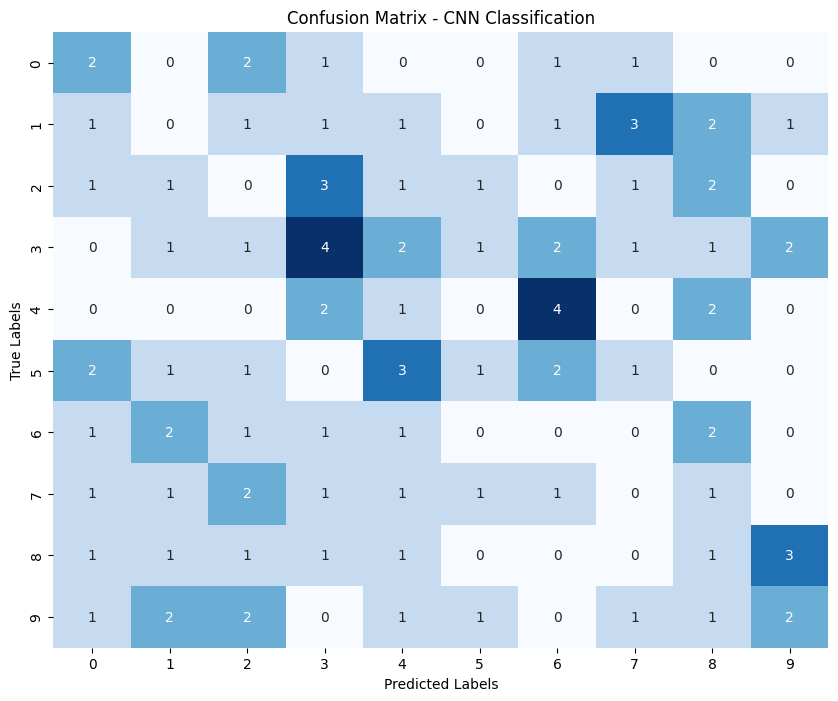

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming you have computed y_pred and y_test for CNN classification
# Replace the placeholder values below with your actual predicted and true labels
y_pred = np.random.randint(0, 10, size=100)  # Placeholder values
y_test = np.random.randint(0, 10, size=100)  # Placeholder values

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix as heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - CNN Classification')
plt.show()